### Modelling Notebook

In [23]:
# importing external libraries
from pathlib import Path
import os
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import warnings
import kaleido
set_config(transform_output = "pandas")

# Importing function to load data

# Making sure any changes are instantly added
%load_ext autoreload
%autoreload 2

from Modules.load_data import load_data
from Modules.preprocessing import missing_summary, dollar_to_int, find_unique_values
from Modules.plotting import Plotter
from Modules.transforming import *
from Modules.modelling import MLearner

# Importing Pipelines
from Modules.Pipelines import Pipeline1, Pipeline2, Pipeline3

import nbformat


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Obtaining Root dir

root = str(Path.cwd())

# Obtaining seed from config.yaml

# Load the config file
with open(root + "/config.yaml", "r") as file:
    config = yaml.safe_load(file)

seed = config["global"]["seed"]

#print(f"seed: {seed}")

# Set global seeds for reproducibility
random.seed(seed)        
np.random.seed(seed)     

# Use the seed in scikit-learn
random_state = check_random_state(seed)

In [3]:
# Obtaining absolute path to data folder

data_folder = str(Path(os.getcwd()) / "data")

In [4]:
# Loading the data from pickle

merged_df = pd.read_pickle(data_folder + "/merged_data.pkl")

In [5]:
# Defining params for CV grid search

params_simple = {"penalty": [None], "solver":["saga"], "class_weight": ["balanced"], "max_iter":[1000]}

params_enhanced = [
    {"penalty": [None], "solver":["saga"], "class_weight": [None, "balanced"]},
    {"penalty": ["elasticnet"], "l1_ratio" : np.linspace(0,1,10).tolist(), 
     "C": np.linspace(0.01,1,10).tolist(), "solver":["saga"], "class_weight": ["balanced"], "max_iter":[1000]}    
]


We will first use the simple parametrs to save computational time and answer the following questions:
1. Is Pipeline2 better than Pipeline1. Is better granularity for date-like columns more predictive?
2. Does using a dataset with a larger amount of "Non-fraudulent transactions" improve performance? As dataset is very imbalanced.

Then we will carry out hyperparameter tuning on GLM and LGBM estimators

### Pipeline1

Transforming date into a time series

In [6]:
ML_pipe1 = MLearner(dataset=merged_df, transformation_pipeline=Pipeline1, params=params_simple, estimator=LogisticRegression(random_state=seed))
ML_pipe1.fit()
ML_pipe1.predict()

% of fraudulent transactions in y_train: 0.1302501302761855
% of fraudulent transactions in y_test: 0.1302954509926528

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.897 total time=   0.7s
[CV 2/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.888 total time=   0.6s
[CV 3/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.901 total time=   0.6s
[CV 4/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.894 total time=   0.7s
[CV 5/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.895 total time=   0.6s
Best parameters found: {'class_weight': 'balanced', 'max_iter': 1000, 'penalty': None, 'solver': 'saga'}
score on training set: 0.8952503091650255
score on testing set: 0.8457047539616347


### Pipeline2

Decomposing date-like features into hours, weeks, etc.

In [7]:
ML_pipe2 = MLearner(dataset=merged_df, transformation_pipeline=Pipeline2, params=params_simple, estimator=LogisticRegression(random_state=seed))
ML_pipe2.fit()
ML_pipe2.predict()

% of fraudulent transactions in y_train: 0.1302501302761855
% of fraudulent transactions in y_test: 0.1302954509926528

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.905 total time=   0.9s
[CV 2/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.904 total time=   0.8s
[CV 3/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.915 total time=   0.8s
[CV 4/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.905 total time=   0.9s
[CV 5/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.914 total time=   0.8s
Best parameters found: {'class_weight': 'balanced', 'max_iter': 1000, 'penalty': None, 'solver': 'saga'}
score on training set: 0.909183531700088
score on testing set: 0.8632022471910112


### Pipeline 3

As we can see the date transformations improve performance. We will now see what an effect increasing the size of the dataset has.

In [9]:
# Set up logging configuration

reduction_p = [0.00125, 0.0025, 0.005, 0.01]

for p in reduction_p:
    print(f"\nMachine learning with {p} of dataset...\n")
    merged_df3_copy = Target0_Reducer(percentage=p).fit_transform(merged_df)

    ML_pipe3 = MLearner(dataset=merged_df3_copy, transformation_pipeline=Pipeline3, params=params_simple, estimator=LogisticRegression(random_state=seed), scoring="f1")
    ML_pipe3.fit()
    ML_pipe3.predict()
    
    


Machine learning with 0.00125 of dataset...

% of fraudulent transactions in y_train: 0.5446467509812473
% of fraudulent transactions in y_test: 0.5463614063777597

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.989 total time=   1.6s
[CV 2/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.990 total time=   1.8s
[CV 3/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.988 total time=   1.7s
[CV 4/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.985 total time=   1.8s
[CV 5/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.986 total time=   1.8s
Best parameters found: {'class_weight': 'balanced', 'max_iter': 1000, 'penalty': None, 'solver': 'saga'}
score on training set: 0.9878182725911133
score on testing set: 0.9453357100415924

Machine learning with 0.0025 of data

Interestingly we see that as we increase the dataframe size performance decreases. Perhaps the model cannot generalise well to so few fraudulent transactions. In addition Logit fails to converge. We propose to use a balanced dataset.

In [10]:
# Obtaining score for balanced class

merged_df3_copy = Target0_Reducer(balanced=True).fit_transform(merged_df)

ML_pipe3 = MLearner(dataset=merged_df3_copy, transformation_pipeline=Pipeline3, params=params_simple, estimator=LogisticRegression(), scoring="f1")
ML_pipe3.fit()
ML_pipe3.predict()

% of fraudulent transactions in y_train: 0.5011501150115012
% of fraudulent transactions in y_test: 0.4965496549654965

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.987 total time=   1.7s
[CV 2/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.984 total time=   1.6s
[CV 3/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.983 total time=   1.8s
[CV 4/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.982 total time=   1.8s
[CV 5/5] END class_weight=balanced, max_iter=1000, penalty=None, solver=saga;, score=0.988 total time=   1.6s
Best parameters found: {'class_weight': 'balanced', 'max_iter': 1000, 'penalty': None, 'solver': 'saga'}
score on training set: 0.9849840891010342
score on testing set: 0.9477623110312827


In [11]:
# Now hyperparameter tuning

merged_df3_copy = Target0_Reducer(balanced=True).fit_transform(merged_df)

ML_pipe3 = MLearner(dataset=merged_df3_copy, transformation_pipeline=Pipeline3, params=params_enhanced, estimator=LogisticRegression(), scoring="accuracy")
ML_pipe3.fit()
ML_pipe3.predict()

% of fraudulent transactions in y_train: 0.5011501150115012
% of fraudulent transactions in y_test: 0.4965496549654965

Fitting 5 folds for each of 102 candidates, totalling 510 fits


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END class_weight=None, penalty=None, solver=saga;, score=0.987 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END class_weight=None, penalty=None, solver=saga;, score=0.984 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END class_weight=None, penalty=None, solver=saga;, score=0.983 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END class_weight=None, penalty=None, solver=saga;, score=0.982 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END class_weight=None, penalty=None, solver=saga;, score=0.988 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END class_weight=balanced, penalty=None, solver=saga;, score=0.987 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END class_weight=balanced, penalty=None, solver=saga;, score=0.984 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END class_weight=balanced, penalty=None, solver=saga;, score=0.983 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END class_weight=balanced, penalty=None, solver=saga;, score=0.982 total time=   0.5s


/home/as3620/miniconda3/envs/FODS_coursework/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END class_weight=balanced, penalty=None, solver=saga;, score=0.988 total time=   0.5s
[CV 1/5] END C=0.01, class_weight=balanced, l1_ratio=0.0, max_iter=1000, penalty=elasticnet, solver=saga;, score=0.968 total time=   0.1s
[CV 2/5] END C=0.01, class_weight=balanced, l1_ratio=0.0, max_iter=1000, penalty=elasticnet, solver=saga;, score=0.971 total time=   0.1s
[CV 3/5] END C=0.01, class_weight=balanced, l1_ratio=0.0, max_iter=1000, penalty=elasticnet, solver=saga;, score=0.970 total time=   0.1s
[CV 4/5] END C=0.01, class_weight=balanced, l1_ratio=0.0, max_iter=1000, penalty=elasticnet, solver=saga;, score=0.973 total time=   0.1s
[CV 5/5] END C=0.01, class_weight=balanced, l1_ratio=0.0, max_iter=1000, penalty=elasticnet, solver=saga;, score=0.976 total time=   0.1s
[CV 1/5] END C=0.01, class_weight=balanced, l1_ratio=0.1111111111111111, max_iter=1000, penalty=elasticnet, solver=saga;, score=0.969 total time=   0.1s
[CV 2/5] END C=0.01, class_weight=balanced, l1_ratio=0.1111111

### LGBM set up with Pipeline3



In [4]:
# Loading the balanced data from pickle

balanced_df = pd.read_pickle(data_folder + "/balanced_data.pkl")

% of fraudulent transactions in y_train: 0.5011501150115012
% of fraudulent transactions in y_test: 0.4965496549654965

Best parameters found: {'learning_rate': 0.1, 'min_child_weight': 0.001, 'n_estimators': 1000, 'num_leaves': 31}

Performance on test set with best parameters: 
Accuracy: 0.96
Recall: 0.95
Precision: 0.97
F1 Score: 0.96


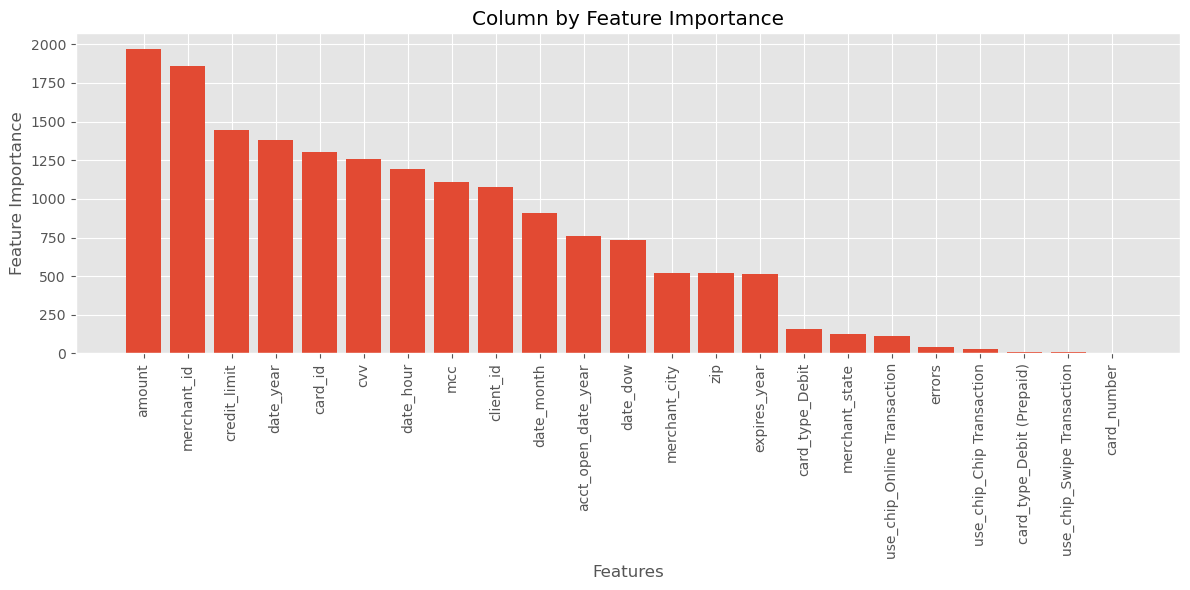

Preparation of a new explainer is initiated

  -> data              : 19998 rows 23 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 19998 values
  -> model_class       : sklearn.model_selection._search.GridSearchCV (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7ff6a1150860> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.51e-17, mean = 0.501, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -4.09e-05, mean = 2.56e-12, max = 3.34e-05
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


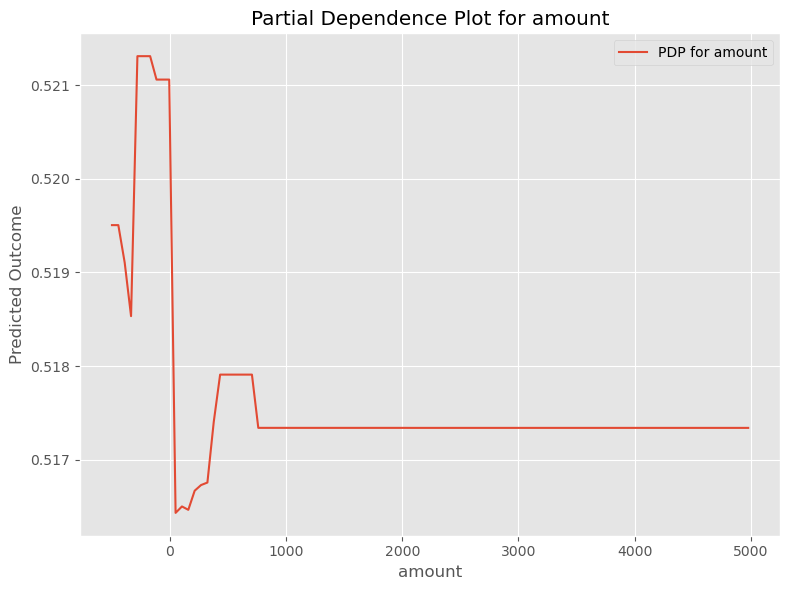

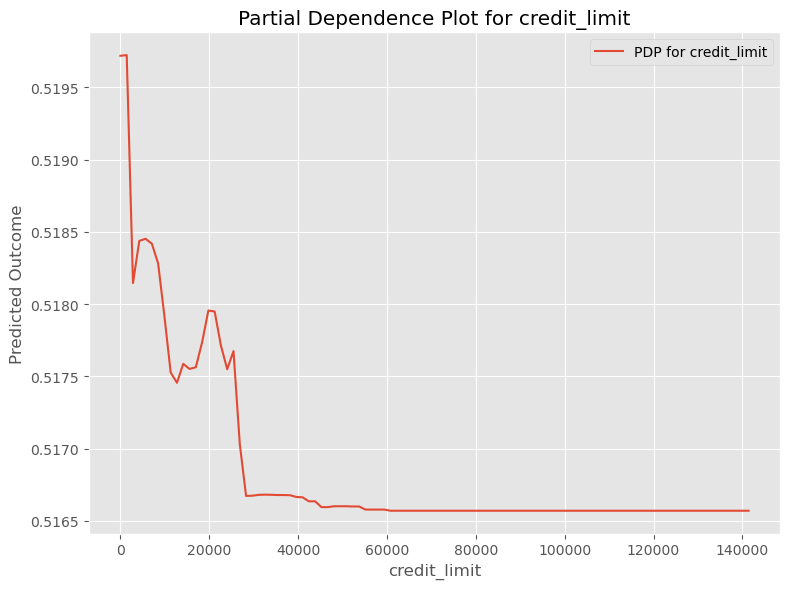

In [25]:
# LGBM params

warnings.filterwarnings("ignore")

lgbm_param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Small values for smoother convergence
    "n_estimators": [250, 500, 1000],   # Large enough for early stopping to determine optimal rounds
    "num_leaves": [31, 50, 70],         # Control tree complexity; larger values for more complex patterns
    "min_child_weight": [0.001 ,1, 5, 10],     # Min data required in a child leaf
}


ML_pipe3 = MLearner(dataset=balanced_df, transformation_pipeline=Pipeline3, params=lgbm_param_grid, estimator=LGBMClassifier(random_state=seed, verbose=-1), scoring="f1",cv=5, verbose=0)
ML_pipe3.fit()
ML_pipe3.predict()
ML_pipe3.explain()
